In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from rdkit import Chem
from tqdm.notebook import tqdm
import multiprocessing as mp

import numpy as np

import score_utils as utils

### Read docking scores

In [2]:
fa = pd.read_csv("./docking_scores/Finasteride_amides_scores.csv")
fe = pd.read_csv("./docking_scores/Finasteride_reaction_enumeration_scores.csv")

### Format the amide set (1 transformation, many buildling blocks)

In [3]:
fa.columns = ["ID","score","d"]
fa["smiles"] = fa.index
fa['source'] = ["amide"] * len(fa)
fa.drop("d",axis=1,inplace=True)

# Remove positive Ns
fa["posN"] =  ["N+" in i for i in fa.smiles]
fa = fa[~fa.posN].copy()
fa.reset_index(drop=True,inplace=True)
fa.drop("posN",axis=1,inplace=True)

In [4]:
fa.head()

,ID,score,smiles,source
0,1365007,-15.358210,C[C@]12CC[C@H]3[C@@H](CC[C@H]4NC(=O)C=C[C@]34C...,amide
1,1365006,-15.496505,C[C@]12CC[C@H]3[C@@H](CC[C@H]4NC(=O)C=C[C@]34C...,amide
2,1365005,-15.117712,CC(=COc1ccccc1)C([S-])=NC(=O)[C@H]1CC[C@H]2[C@...,amide
3,1365002,-15.943045,Cc1nocc1/C=C/CCN(C)C(=O)[C@H]1CC[C@H]2[C@@H]3C...,amide
4,1365000,-14.834363,COCc1ccc(N(F)C(=O)[C@H]2CC[C@H]3[C@@H]4CC[C@H]...,amide


### Get heavy atom count (HAC)

In [5]:
if __name__ == '__main__':
    with mp.Pool(8) as p:
        n_atoms = p.map(utils.count_atoms, fa.smiles,chunksize=10000)

In [6]:
fa["natoms"] = n_atoms

finas_atoms = utils.count_atoms("O=C(NC(C)(C)C)[C@@H]2[C@]1(CC[C@H]3[C@H]([C@@H]1CC2)CC[C@H]4NC(=O)\C=C/[C@]34C)C")
finas_atoms

27

### Format the enumerated set

In [7]:
fe.columns = ["ID","score","d"]
fe["smiles"] = fe.index
fe.reset_index(drop=True,inplace=True)
fe['source'] = ["enumerated"] * len(fe)
fe.drop("d",axis=1,inplace=True)

fe_valid = fe[~fe.score.isnull()].copy()
fe_valid.reset_index(drop=True,inplace=True)
fe_valid.head()

,ID,score,smiles,source
0,35921684_S2,-14.856669,CC12C=C(N3CC3(C)C)CC[C@H]1[C@@H]1CC[C@H]3NC(=O...,enumerated
1,35921688_S2,-14.564507,CC12CC[C@H]3[C@@H](CC[C@H]4NC(=O)C=C[C@]34C)[C...,enumerated
2,35921650_S2,-13.507662,CC12CC[C@H]3[C@@H](CC[C@H]4NC(=O)C=C[C@]34C)[C...,enumerated
3,35921660_S2,-15.668927,CC12C=C(ON3CC3(C)C)CC[C@H]1[C@@H]1CC[C@H]3NC(=...,enumerated
4,35921642_S2,-15.897118,CC12C=C(OON3CC3(C)C)CC[C@H]1[C@@H]1CC[C@H]3NC(...,enumerated


### Plot trellised docking score against HAC for the amide set 

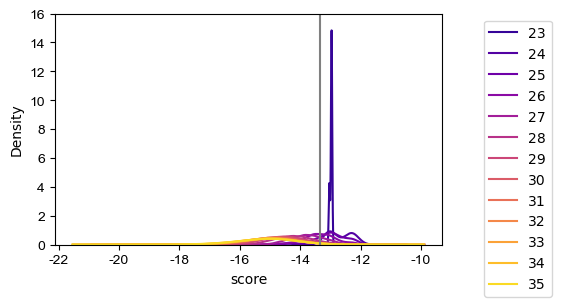

In [8]:
sns.set_palette("plasma",n_colors=13)
plt.figure(figsize=(5,3))
for n_at in range(23,36):
    df_plot = fa[fa.natoms <= n_at]
    sns.kdeplot(data=df_plot,x="score")
    
    
ax = plt.gca()

ax.set_xticks(range(-22,-9,2))
ax.set_xticklabels(range(-22,-9,2),font="Arial")

ax.set_yticks(range(0,17,2))
ax.set_yticklabels(range(0,17,2),font="Arial")

plt.legend(labels=[str(i) for i in range(23,36)],bbox_to_anchor=(1.3, 1.0), loc='upper right')

plt.gca().axvline(-13.337088,color="grey")

plt.savefig("finasteride_2335_kde.svg",format="svg")

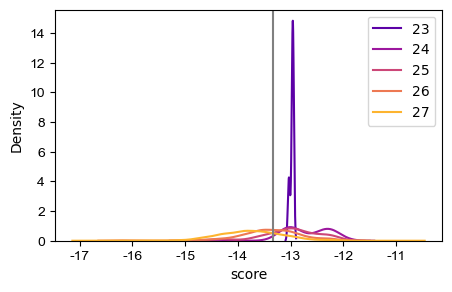

In [9]:
# Smaller set up to HAC of Finasteride
sns.set_palette("plasma",n_colors=5)
plt.figure(figsize=(5,3))
for n_at in range(23,28):
    df_plot = fa[fa.natoms <= n_at]
    sns.kdeplot(data=df_plot,x="score")
    
ax = plt.gca()

ax.set_xticks(range(-17,-10,1))
ax.set_xticklabels(range(-17,-10,1),font="Arial")

ax.set_yticks(range(0,15,2))
ax.set_yticklabels(range(0,15,2),font="Arial")

plt.legend(labels=[str(i) for i in range(23,28)])
plt.gca().axvline(-13.337088,color="grey")

plt.savefig("finasteride_2327_kde.svg",format="svg")

### Search and tag presence of the Finasteride ring structure

In [10]:
if __name__ == '__main__':
    with mp.Pool(24) as p:
        has_finas_base = p.map(utils.has_finas_base, fe_valid.smiles,chunksize=10000)

In [11]:
fe_valid["has_finas"] = has_finas_base

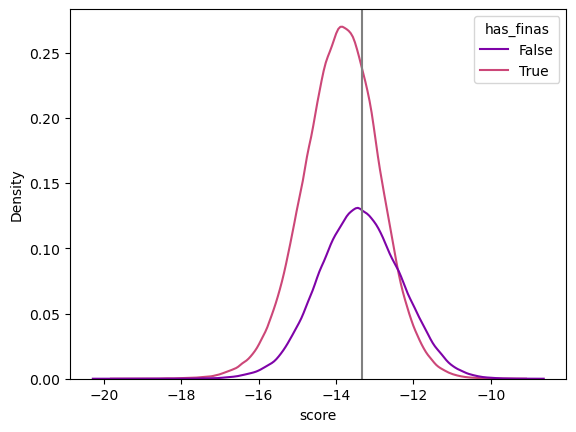

In [14]:
# See how presence of the ring structure affects docking score

sns.set_palette("plasma",n_colors=3)
sns.kdeplot(data=fe_valid, x="score", hue="has_finas")
plt.gca().axvline(-13.337088,color="grey")

In [17]:
# read edit distances for reaction enumeration set
s1 = pd.read_csv("./data_files/cleaned_side1.csv")
s2 = pd.read_csv("./data_files/cleaned_side2.csv")
s3 = pd.concat((s1,s2))

In [18]:
s3.reset_index(drop=True,inplace=True)

In [19]:
dist_dict = {stag:dist for stag,dist in zip(list(s3.structure_tag),list(s3.distance))}

In [20]:
fe_valid["distance"] = [dist_dict[i] for i in fe_valid["ID"]]

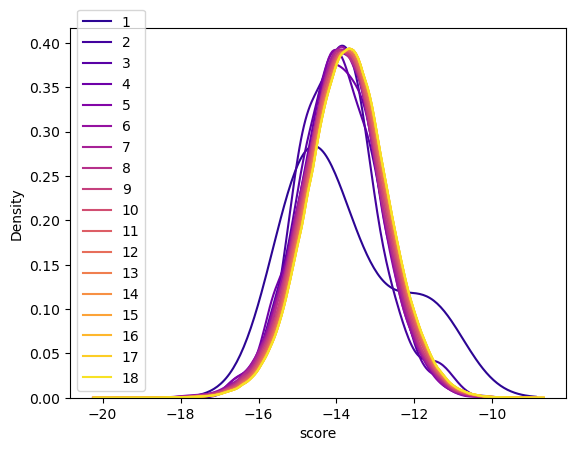

In [21]:
# examine score vs edit distance
use_df = fe_valid

sns.set_palette("plasma",n_colors=18)
for dist in range(1,19):
    df_plot = use_df[use_df.distance <= dist]
    sns.kdeplot(data=df_plot,x="score")
plt.legend(labels=[str(i) for i in range(1,19)])
# plt.legend(labels=[str(i) for i in range(23,36)])
# plt.gca().axvline(-13.337088,color="grey")

### Apply filters and plot

In [22]:
fa_plot = fa[fa.natoms <= 28].copy()
fa_plot.drop("natoms",inplace=True,axis=1)

fe_plot = fe_valid[(fe_valid.has_finas) & (fe_valid.distance<=6)].copy()
fe_plot.drop(["has_finas","distance"],axis=1,inplace=True)

In [23]:
f_all = pd.concat((fa_plot,fe_plot))

f_all.reset_index(drop=True,inplace=True)

In [24]:
fa_avg = np.mean(fa_plot.score)
fe_avg = np.mean(fe_plot.score)

Text(0.5, 1.0, 'finasteride')

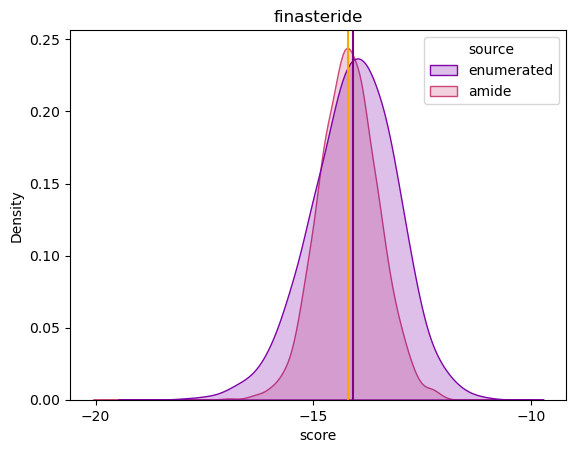

In [29]:
sns.set_palette("plasma",n_colors=3)
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.5)
sns.kdeplot(data=f_all.sort_values("source",ascending=False), x="score",hue="source",clip_on=True,fill=True,bw_method=0.2)
ax = plt.gca()
ax.axvline(fa_avg,color="orange")
ax.axvline(fe_avg,color="purple")
ax.set_xticks((-20,-15,-10))
ax.set_title("finasteride")
# plt.gca().axvline(-13.337088,color="grey")

# plt.savefig("finasteride_score_compare.svg",format="svg")